In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
direccion= "properati.csv"
data_original=pd.read_csv(direccion, sep=',')
print(data_original.shape)
print(data_original.columns)
data_original.head(3)

(121220, 26)
Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


#### Análisis general 
Se crean funciones para haer un análisis general del dataset:

In [3]:
def data_creacion(data_original):
    #nulls por fila original
    data_original["null_fila"]=data_original.isnull().sum(axis=1)
    
    #nulls por fila
    campos_ignorar= ["floor","rooms","expenses","geonames_id","lat-lon","lat","lon"]
    data_pocos_campos_nulos=data_original.drop(campos_ignorar,axis=1)
    data_pocos_campos_nulos["null_fila"]=data_pocos_campos_nulos.isnull().sum(axis=1)

    #categoricas - numericas
    columnas_categorica=data_original.select_dtypes(include="object").columns
    data_categorica=data_original.loc[:,columnas_categorica]
    data_numerica=data_original.drop(columnas_categorica,axis=1)
    
    return data_categorica,data_numerica,data_pocos_campos_nulos


In [4]:
data_categorica,data_numerica,data_pocos_campos_nulos=data_creacion(data_original)


Se observan los nulos en las *columnas* para tratar de analizar que datos es posible imputar y que columnas se deberán eliminar.

In [5]:
# Nulls Columnas
data_original.isnull().sum()*100/data_original.shape[0]


Unnamed: 0                     0.000000
operation                      0.000000
property_type                  0.000000
place_name                     0.018974
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
surface_total_in_m2           32.443491
surface_covered_in_m2         16.422208
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000


#### Duplicados

En primer lugar se analiza si hay registros *duplicados*. Se examinan los registros que comparten los valores en las columnas **state_name**, **place_name**, **title**, **surface_total_in_m2**, **description**, **price_usd_per_m2** e **image_thumbnail**. Dado que es posible que en un mismo edificio haya publicaciones similares en los casos de desarrollos inmobiliarios (pozo), se define analizar por un lado los registros donde la columna **propery_type** no sea "aparment" y por el otro, en el caso de los registros de "apartment", se observará si corresponden o no a la misma propiedad a traves de la revisión de **descripcion** y **título**. 

In [6]:
contador_busqueda_mask= data_original.duplicated(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")
contador_busqueda=data_original.loc[contador_busqueda_mask]
no_apartament=contador_busqueda.property_type!="apartment"
no_apartamentm=contador_busqueda[no_apartament]
no_apartamentm.shape

(172, 27)

In [7]:
contador_busqueda_mask= data_original.duplicated(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")
contador_busqueda=data_original.loc[contador_busqueda_mask]
apartmentmask=contador_busqueda.property_type=="apartment"
apartment=contador_busqueda[apartmentmask]
apartment.shape

(1551, 27)

In [8]:
apartment["title"].head(10)

245    Departamentos monoambiente, zona parque Indepe...
247    Departamentos monoambiente, zona parque Indepe...
248    Departamentos monoambiente, zona parque Indepe...
249    Departamentos monoambiente, zona parque Indepe...
250    Departamentos monoambiente, zona parque Indepe...
959           Departamento en Venta ubicado en Chacarita
960           Departamento en Venta ubicado en Chacarita
970           Departamento en Venta ubicado en Chacarita
971           Departamento en Venta ubicado en Chacarita
972           Departamento en Venta ubicado en Chacarita
Name: title, dtype: object

In [9]:
apartment["description"].head(10)

245    Departamento de un ambiente al contrafrente co...
247    Departamento de un ambiente al contrafrente co...
248    Departamento de un ambiente al contrafrente co...
249    Departamento de un ambiente al contrafrente co...
250    Departamento de un ambiente al contrafrente co...
959    Venta - Departamento - Argentina, Buenos Aires...
960    Venta - Departamento - Argentina, Buenos Aires...
970    Venta - Departamento - Argentina, Buenos Aires...
971    Venta - Departamento - Argentina, Buenos Aires...
972    Venta - Departamento - Argentina, Buenos Aires...
Name: description, dtype: object

Conlcuimos que no se podía determinar si corresponden a desarrollos inmobiliarios, por lo cual se define eliminar los duplicados considerando como tales a los registros que tengan los mismos valores en las columnas **state_name**, **place_name**, **title**, **surface_total_in_m2**, **description**, **price_usd_per_m2** e **image_thumbnail**.

In [10]:
data_original= data_original.drop_duplicates(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")

#### Columas "floor" y "expenses"

Las columnas **"floor"** y **"expenses"** tienen un porcentaje muy importante de nulos. Se analiza si los nulos corresponden a los registros que no son apartment, en cuyo caso sería correcto que estén vacíos.&nbsp;


Se observa que en "apartment" también es muy alto el porcentaje de nulos por lo que se define eliminar la columna (será realizado al finalizar la limpieza de datos).



In [11]:
mask_apart = data_original["property_type"] =="apartment"
data_apart = data_original.loc[mask_apart, :]
data_apart.isnull().sum()*100/data_apart.shape[0]

Unnamed: 0                     0.000000
operation                      0.000000
property_type                  0.000000
place_name                     0.001439
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   12.361539
lat-lon                       40.896798
lat                           40.896798
lon                           40.896798
price                         15.327848
currency                      15.327848
price_aprox_local_currency    15.327848
price_aprox_usd               15.327848
surface_total_in_m2           27.749806
surface_covered_in_m2         15.619875
price_usd_per_m2              38.661277
price_per_m2                  25.898380
floor                         90.637857
rooms                         55.535576
expenses                      84.019047
properati_url                  0.000000
description                    0.002877
title                          0.000000


#### Columna "rooms"

Se observan muchos nulos en la columna **"rooms"**, se intentará recuperar esta infomación a través de la búsqueda con expresiones regulares en **description** de "Ambientes" y "Habitaciones (sabiendo que no son sinonimos con el fin de conocer con qué información se cuenta). Se generan nuevas columnas con estos valores y se evalúa la cantidad de nulos. 

In [12]:
def patron_ambientes(data, patron):
    patron_ambientes = patron
    regex = re.compile(patron_ambientes, flags= re.IGNORECASE)
    ambientes_descripcion = data["description"].apply(lambda x:None if x is np.NaN else regex.search(x))
    return ambientes_descripcion

In [13]:
ambientes_descripcion = patron_ambientes(data_original, "(?P<cantidad_ambientes>\d+)\s*amb\D*")

print(ambientes_descripcion.notnull().sum())

37742


In [14]:
cantidad_ambientes_descripcion = ambientes_descripcion.apply(lambda x: x if x is None else x.group("cantidad_ambientes"))
rooms=data_original["rooms"]

In [15]:
#Agregamos la cantidad de ambientes definida en la descrpición a la columna rooms y analizamos la cantidad de nulos

ambientes = rooms.combine_first(cantidad_ambientes_descripcion)
print("porcentaje de nulos: ", ambientes.isnull().sum()*100/ambientes.shape)

porcentaje de nulos:  [44.74338268]


In [16]:
#Agregamos la cantidad de habitaciones definida en la descrpición a la columna rooms y analizamos la cantidad de nulos:

habitaciones_descripcion = patron_ambientes(data_original, "(?P<habitaciones>\d+)\s*habitacion\D*")
print(habitaciones_descripcion.notnull().sum())

2749


In [17]:
cantidad_habitacioness_descripcion = habitaciones_descripcion.apply(lambda x: x if x is None else x.group("habitaciones"))
ambientes_hab = ambientes.combine_first(cantidad_habitacioness_descripcion)
print("porcentaje de nulos: ", ambientes_hab.isnull().sum()*100/ambientes.shape)

porcentaje de nulos:  [43.74252073]


Dado que el procentaje de información nula es muy alta, se define eliminar la columna **rooms** (será realizado al finalizar la limpieza de datos).

#### Ubicación

Se define qué variables utilizar para la ubicación de la propiedad.&nbsp;

Hay 4 columnas en el dataset:&nbsp;

**country_name**: Corresponde al país, en todos los casos el valor es "Argentina".&nbsp;

**state_name**: Corresponde a las provincias y se encuentra completa.&nbsp;

**place_with_parent_names**: Está formada por distintos valores separados por "|", país, provincia, localidad (o barrio en Capital Federal) y barrio.&nbsp;

**place_name**: Corresponde al último registro de "place_with_parents_names", dependiendo el caso se refiere a la provincia, la localidad o el barrio.&nbsp;

Se realizará un análisis de cada una.


La columna **country_name** tiene en todos los registros el mismo valor: "Argentina", por lo que se define eliminar esta columna (será realizado al finalizar la limpieza de datos)

In [18]:
data_original["country_name"].value_counts()

Argentina    119497
Name: country_name, dtype: int64

En la columna **state_name** se observa que "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Buenos Aires Interior", "Capital Federal", "Córdoba" y "Santa Fe" representan el 94.06% del dataset.
Respecto de las otras provincias se observan poca cantidad de datos.


In [19]:
data_prov = data_original.groupby("state_name")
print(data_prov.size())
print(data_prov.size()*100/121220)


state_name
Bs.As. G.B.A. Zona Norte        25293
Bs.As. G.B.A. Zona Oeste         9304
Bs.As. G.B.A. Zona Sur          13863
Buenos Aires Costa Atlántica     9955
Buenos Aires Interior            2278
Capital Federal                 31661
Catamarca                          27
Chaco                              57
Chubut                            259
Corrientes                        582
Córdoba                         11796
Entre Ríos                        369
Formosa                            65
Jujuy                              26
La Pampa                          155
La Rioja                            4
Mendoza                           677
Misiones                          457
Neuquén                           713
Río Negro                         804
Salta                             276
San Juan                           40
San Luis                          246
Santa Cruz                         20
Santa Fe                         9866
Santiago Del Estero                 4
T

Respecto de la columna **place_name** se observan 23 datos nulos. Se puede observar a través de los valores de la columna **place_with_parent_names** que corresponden a Tigre. Por lo que se define imputar esos valores

In [20]:
print(data_original["place_name"].isnull().sum())
data_original.loc[(data_original["place_name"].isnull()), :]

23


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila
6489,6489,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4008968545,-58.63809847",-34.400897,...,2708.333333,2708.333333,NaN,NaN,NaN,http://www.properati.com.ar/15ui7_venta_casa_t...,"Espectacular casa moderna de una planta, con a...",Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/7/vQjgbHSz1fKXxy...,5
10201,10201,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.400704,-58.638067",-34.400704,...,NaN,1783.333333,NaN,5.0,NaN,http://www.properati.com.ar/166p5_venta_casa_t...,Corredor Responsable: SABRINA COCCONI - CSI 62...,VENTA CASA SANTA MARÍA DE TIGRE COUNTRY BARRIO...,https://thumbs4.properati.com/1/FABpKIJMaoAO3t...,6
11451,11451,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026880384,-58.6262613379",-34.402688,...,253.456221,2037.037037,NaN,NaN,NaN,http://www.properati.com.ar/16bpd_venta_casa_t...,MUY LINDA CASA EN EXCELENTE UBICACION!! Superf...,SANTA MARIA DE TIGRE IMPECABLE,https://thumbs4.properati.com/5/fwH9L71hW2rW7V...,5
14839,14839,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4007994779,-58.6381735719",-34.400799,...,2000.000000,2400.000000,NaN,NaN,NaN,http://www.properati.com.ar/16tal_venta_casa_b...,Muy linda casa de estilo clásico.-Planta baja;...,Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/1/3ZbPSffTY38y7v...,5
18622,18622,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4032781195,-58.6263503945",-34.403278,...,3814.705882,3814.705882,NaN,NaN,NaN,http://www.properati.com.ar/177ee_venta_casa_t...,Casa con increible vista al lago con playa de...,Casa con increible vista al lago con playa y m...,https://thumbs4.properati.com/0/52JCH1PKYCOMe6...,5
21922,21922,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.399704,-58.638405",-34.399704,...,NaN,2000.000000,NaN,5.0,NaN,http://www.properati.com.ar/17gy5_venta_casa_s...,Corredor Responsable: Matias Castelli - CUCICB...,Venta Casa - Barrio Santa Maria de Tigre,https://thumbs4.properati.com/8/oO7kmFPYNm8DYr...,6
23664,23664,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4005161998,-58.6417999185",-34.400516,...,1632.653061,1632.653061,NaN,NaN,NaN,http://www.properati.com.ar/17mb5_venta_casa_t...,EXCELENTE CASA CLASICA con grandes ventanas y ...,CASA EN VENTA EN SANTA MARIA DE TIGRE CON RENTA,https://thumbs4.properati.com/2/LQCwH6txpFqetn...,5
24722,24722,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4007292,-58.6377783",-34.400729,...,1677.215190,1962.962963,NaN,NaN,NaN,http://www.properati.com.ar/17oz1_venta_casa_t...,"EN EXCLUSIVIDAD!!!!!!Lindísima casa, muy lumin...",Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/0/Nhx4NejZaQACap...,5
38856,38856,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.425087,-58.5796585",-34.425087,...,NaN,2454.545455,NaN,NaN,NaN,http://www.properati.com.ar/18mcb_venta_casa_t...,SANTA MARIA DE TIGRE- AL RIO - ESPECTACULAR CA...,"Casa (barrio cerrado), Venta",https://thumbs4.properati.com/2/Izq8d5o8ti3kJy...,7
45970,45970,sell,apartment,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.396074,-58.63738",-34.396074,...,1727.272727,3518.518519,NaN,1.0,NaN,http://www.properati.com.ar/1958f_venta_depart...,"EDIFICIO ZERENA – EL PALMAR, NORDELTA. Torre 2...",Excelente monoambiente. Barrio El Palmar. Con...,https://thumbs

Se completa la columna reemplazando los valores nulos en una Series (para que no reemplace los nulos en todo el dataset) y se realiza un join de la nueva columna llamada: **place_name_completo**. Se elimina la columna **place name**.

In [21]:
place_name = data_original["place_name"]
ubicacion = place_name.replace(np.NaN, "Tigre")
data_ubicacion = data_original.join(ubicacion, rsuffix='_completo')

In [22]:
data_ubicacion=data_ubicacion.drop(columns = "place_name",axis=1)

In [23]:
data_ubicacion.head(3)

,Unnamed: 0,operation,property_type,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila,place_name_completo
0,0,sell,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,3,Mataderos
1,1,sell,apartment,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,7,La Plata
2,2,sell,apartment,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,3,Mataderos


La columna **place_with_parents_names** está compuesta por distintos valores, se crea una función para identificar cada uno con expresiones regulares. Se recupera la 3er columna que corresponde a la localidad (el barrio en el caso de Capital Federal). Este valor en algunos casos coincidirá con **place_name** (cuando no haya exista el 4to valor correspondiente al barrio). &nbsp;

Se utilizará para los análisis la localidad debido a que **place_name** tiene distintos grados de agregación, y en algunos casos es demasiado espefíca.

In [24]:
def dividir_columna(data):
    patron_columna =patron_columna ="^(\|)(?P<pais>Argentina)(\|)(?P<provincia>[\w\s\.]+)(\|)(?P<localidad>[\w\s\./-]+)(\|)(?P<barrio>[\w\s\./-]*)(\|?)"
    regex_place = re.compile(patron_columna)
    columnas = data["place_with_parent_names"].apply(lambda x: regex_place.search(x))
    localidad = columnas.apply(lambda x: x if x is None else x.group("localidad"))
    return localidad


In [25]:
localidad = dividir_columna(data_ubicacion)

Se realiza un join y se incorpora **place_wiht_parents_name_localidad** con el 3er valor de la columna **place_with_parent_names** y se elimina **place_with_parent_names** 

In [26]:
data_localidad = data_ubicacion.join(localidad, rsuffix='_localidad')

In [27]:
data_localidad=data_localidad.drop(columns = "place_with_parent_names",axis=1)

data_localidad.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila,place_name_completo,place_with_parent_names_localidad
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,3,Mataderos,Mataderos
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,7,La Plata,La Plata
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,3,Mataderos,Mataderos


Se observa que hay 4476 valores nulos en **place_with_parents_name_localidad** que corresponden a los registros que solo tenían dos datos en **place_with_parents_names** (país y provincia), debido a esto en la columna **place_name** se encuentra el dato de provincia. Se analiza si es posible imputar la localidad en base a **description** o **title**.

In [28]:
print(data_localidad["place_with_parent_names_localidad"].isnull().sum())
nulos_localidad = data_localidad[data_localidad["place_with_parent_names_localidad"].isnull()]

#Se observan cuántos nulos hay en cada provincia para ver buscar posibles imputaciones
nulos_localidad["state_name"].value_counts()

4476


Córdoba                         2557
Capital Federal                 1095
Bs.As. G.B.A. Zona Norte         222
Mendoza                          128
Buenos Aires Interior            106
Tucumán                           76
Bs.As. G.B.A. Zona Oeste          65
Misiones                          42
Santa Fe                          32
Buenos Aires Costa Atlántica      27
Bs.As. G.B.A. Zona Sur            24
Salta                             21
San Luis                          19
Chubut                            17
Neuquén                           10
Río Negro                          8
San Juan                           7
Tierra Del Fuego                   6
Santiago Del Estero                3
La Pampa                           3
Catamarca                          3
Corrientes                         2
Jujuy                              1
Chaco                              1
La Rioja                           1
Name: state_name, dtype: int64

In [29]:
#Se prueba buscando en la Capital Federal
#A primera vista se observa por "title" y "description" que no todos las propiedades son efectivamente de Capital Federal

data_capital_federal = nulos_localidad.loc[(nulos_localidad["state_name"]=="Capital Federal"), :]
data_capital_federal.title.head(10)

108    Casa 180m² con 2 Plantas en Navarro, Julián 29...
110    Casa 744m² con 2 Plantas en Del Valle Iberluce...
115    Casa 720m² con Plantas en Palma, Diego 1800, A...
119    Casa 200m² con Cochera en Barbosa, Gerónimo 14...
121    Casa 340m² con Cochera en Palma, Diego 1300, A...
311    Casa 741m² con 2 Plantas, Argentina, Capital F...
315    Casa 160m² con 3 Plantas en Marconi, Ing. 2400...
316    Casa 125m² con 3 Plantas en Lezica, Martín 300...
317    Casa 125m² con 3 Plantas en Lezica, Martín 300...
326    Casa 1050m² con 3 Plantas, Argentina, Capital ...
Name: title, dtype: object

Se intenta buscando barrios para ver si es posible imputar los valores de "ubicacion" a través de **description**.

In [30]:
def imputar_barrio(data, patron):
    patron_barrio = patron
    regex_barrio = re.compile(patron_barrio, flags=re.IGNORECASE)
    barrio_search = data["description"].apply(lambda x: None if x is np.NaN else regex_barrio.search(x))
    barrio = barrio_search.apply(lambda x: x if x is None else x.group(0))
    return barrio
    
data_villa_crespo = imputar_barrio(data_capital_federal, "Villa Crespo")


In [31]:
mask_villa_crespo = data_villa_crespo.notnull()
villa_crespo = data_capital_federal.loc[mask_villa_crespo, :]
villa_crespo["description"].value_counts()

#Se observa que aunque aparece Villa Crespo en la descripción, se refiere a la ubicación de la inmobiliaria, por lo que no es una buena manera de imputar los barrios

Este emprendimiento está ubicado en pleno barrio de Villa Crespo, único lote en esquina de 1.800m2 con excelentes vistas a la ciudad. El edificio de 12 pisos contará con departamentos de 1, 2, 3 y 4 ambientes, y excelentes amenties que le brindarán un espacio de recreación y confort inigualable.La unidad publicada es la 5º21CUCICBA Mat. 1544    1
Venta de local en galeria, en el barrio de Microcentro, muy buena ubicación.Superficie total y cubierta de 23 m2.Tiene un entrepiso, actualmente funciona una libreria.Posee teléfono de línea, expensas $600.Consultar por venta de local + fondo de comercio.Grupo Mega Op. ScalabriniTel: Av Scalabrini Ortiz 393 - Villa Crespo. CABA                  1
Casa de 3 amb con living comedor, baño y toilette. Con terraza y cochera. sup total: 160 m2. En el Barrio Villa General Mitre en cercanía del metrobus.U$D 300.000Grupo Mega Op. ScalabriniTel: Av Scalabrini Ortiz 393 - Villa Crespo. CABA                                                                  

In [32]:
#Se prueba busando una localidad:

data_san_bernardo = imputar_barrio(nulos_localidad, "san bernardo")

print(data_san_bernardo.notnull().sum())
mask_san_bernardo = data_san_bernardo.notnull()
san_bernardo = nulos_localidad.loc[mask_san_bernardo, :]
san_bernardo["description"].value_counts().tail(5)

#Se observa que "San Bernardo" también lo encuentra como barrio de la localidad de Luján.

13


Dúplex a 4 cuadras de la playa, 2 de Av. San Bernardo y 3 de Av. Chioza - Ideal vivienda permanente, amoblamiento opcional.Planta baja: Patio (posible cochera) Estar comedor - Cocina - Baño, atrás patio con parrilla. Planta Alta: ambiente distribuidor, 2 Domitorios (uno de ellos por escalera interna acceso a 3º dormitorio o escritorio de 3 x 3) y Baño. Gastos de Escritura a cargo del comprador.-Comisión 4% más IVANota: Las medidas que conforman la superficie son aproximadas solo a fines informativos, las reales y valederas surgirán del titulo y/o planos correspondientes.-Inmobiliaria Eduardo FernandezSitio de Montevideo 92, Esquina V. Sarsfield, Lanus Oeste /                                                                                                                                                                                                                                                                                                                                             

Se concluye que no es posible imputar los valores nulos en **place_with_parent_names_localidad** ya que no es confiable la información (tampoco es posible confirmar a qué provincia pertenece). Debido a esto se eliminan los registros.

In [33]:
def elimino_filas(data, columna):
    data_completa=data.dropna(subset=[columna], axis=0)
    return data_completa

data_completa = elimino_filas(data_localidad, "place_with_parent_names_localidad")

#Revisamos que este bien realizada la operación:
print(data_completa.place_with_parent_names_localidad.isnull().sum())
print(data_localidad.shape)
print(data_completa.shape)
print(119497-115021)
#La diferencia son los 4476 registros de localidad vacios

0
(119497, 27)
(115021, 27)
4476


#### Precio

Por otro lado es necesario analizar el precio. Observamos las siguientes columnas: 
**price_aprox_local_currency**,
**price_aprox_usd**,
**price_usd_per_m2**( corresponde al precio por m2 total), **price_per_m2** (corresponde al precio por m2 cubierto)



In [34]:
print("nulos de precio en $", data_completa["price_aprox_local_currency"].isnull().sum())
print("nulos de precio en U$D", data_completa["price_aprox_usd"].isnull().sum())
print("nulos de precio en U$D por m2", data_completa["price_usd_per_m2"].isnull().sum())
print("nulos de precio en U$D por m2", data_completa["price_per_m2"].isnull().sum())


nulos de precio en $ 18736
nulos de precio en U$D 18736
nulos de precio en U$D por m2 49098
nulos de precio en U$D por m2 30975


El tipo de cambio utilizado en la base es 17.6445 que corresponde al año del dataset. Se utilizarán los valores de precio en USD y se eliminará la columna **price_aprox_local_currency** (será realizado al finalizar la limpieza de datos). 


In [35]:
tipo_de_cambio = data_completa["price_aprox_local_currency"]/data_completa["price_aprox_usd"]
tipo_de_cambio[0]

17.6445

En virtud de la variedad de datos y la falta de información se definió que la mejor manera de realizar los análisis eran a partir del precio por m2 total de cada propiedad. En ese sentido se definió imputar **price_usd_per_m2** tomando en cuenta **place_with_parent_names_localidad** y **propery_type**. &nbsp;

En primer lugar, se observa que hay valores de **state_name** y **place_with_parent_names_localidad** con pocos registros. Además al agruparlo por **propery_type** muchos grupos no cuentan con suficientes cantidad de registros para poder realizar la imputación de una manera confiable. Debido a esto se define utilizar solamente los agrupamientos que tengan 5 o más registros. 

In [36]:
cant_por_grupo = data_completa.groupby(by=["place_with_parent_names_localidad", "property_type"]).agg(cantidad_por_grupo=("Unnamed: 0", "count"))
data_con_cant =pd.merge(data_completa, cant_por_grupo, left_on=["place_with_parent_names_localidad",'property_type'], right_index=True, how='left')
data_hasta_5=data_con_cant.loc[(data_con_cant["cantidad_por_grupo"]>=5),:]

print(data_completa.shape)
print(data_hasta_5.shape)

#revisamos la operación
agrupado = data_hasta_5.groupby(by=["place_with_parent_names_localidad", "property_type"])
agrupado["Unnamed: 0"].count().sort_values()
#Se eliminan 900 registros

(115021, 27)
(114121, 28)


place_with_parent_names_localidad  property_type
Parque Chas                        house               5
Villa Ortuzar                      house               5
Oliva                              house               5
Paraná                             PH                  5
                                   store               5
                                                    ... 
Córdoba                            apartment        3789
Tigre                              apartment        4053
                                   house            4804
Mar del Plata                      apartment        5341
Rosario                            apartment        7140
Name: Unnamed: 0, Length: 622, dtype: int64

Se resolvió eliminar los valores de **price_usd_per_m2** considerados outliers previo a realizar la imputación para no evitar una imputación errórea que distrorsione el dataset.

In [37]:
q1=data_hasta_5["price_usd_per_m2"].quantile(0.25)
q2 = data_hasta_5["price_usd_per_m2"].quantile(0.5)
q3= data_hasta_5["price_usd_per_m2"].quantile(0.75)
q4 = data_hasta_5["price_usd_per_m2"].quantile(1)
interq=q3-q1

umbral_bajo = q1 - (1.5*interq)
umbral_alto = q3 + (1.5*interq)


outlier_alto = data_hasta_5["price_usd_per_m2"] > umbral_alto
outlier_bajo = data_hasta_5["price_usd_per_m2"] < umbral_bajo
outlier_mask = np.logical_or(outlier_alto , outlier_bajo )
sin_outliers = np.logical_not(outlier_mask)
outliers = data_hasta_5["price_usd_per_m2"][outlier_mask]
print(umbral_alto)

data_limpia=data_hasta_5[sin_outliers]
print("Se eliminan:", data_hasta_5.shape[0] - data_limpia.shape[0])

4400.0
Se eliminan: 2752


Se genera una función a fin de analizar los valores por ubicacion y **property_type** para poder imputar los precios. 

In [38]:
def generar_campos_para_imputar(data, columna):
    precio_m2_prom = data.groupby(by=[columna,"property_type"]).agg(price_m2_prom=("price_usd_per_m2","mean"))
    desvio_por_grupo = data.groupby(by=[columna,"property_type"]).agg(price_m2_desv=("price_usd_per_m2","std"))
    cant_por_grupo = data.groupby(by=[columna,"property_type"]).agg(cant=("price_usd_per_m2",'count'))
    q1_por_grupo = data.groupby(by=[columna,"property_type"])["price_usd_per_m2"].quantile(0.25).to_frame("q1")
    q3_por_grupo = data.groupby(by=[columna,"property_type"])["price_usd_per_m2"].quantile(0.75).to_frame("q3")
    data_con_campo_a_imputar = pd.merge(data, precio_m2_prom, left_on=[columna,'property_type'], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, desvio_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar["coef_var"] = data_con_campo_a_imputar["price_m2_desv"]/data_con_campo_a_imputar["price_m2_prom"]
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, cant_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, q1_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, q3_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    return data_con_campo_a_imputar

Se crea una función para poder estimar **precio_usd_per_m2** en los casos que se cuente con la información de **price_usd_per_m2"

In [39]:
def completar_datos_para_estimar(data):
    precios_m2_imputados=data.apply(
        lambda x: x["price_aprox_usd"] / x["surface_total_in_m2"] 
                if pd.isnull(x["price_usd_per_m2"]) and  x["surface_total_in_m2"]>0
                else x["price_usd_per_m2"]  , axis=1) 
    data_original["price_usd_per_m2"]=precios_m2_imputados
    return datos_para_imputar

Se crea una función para eliminar los outliers en el campo **price_usd_per_m2**.

In [40]:
def eliminar_outliers(data):
    outlier_alto = (data["price_usd_per_m2"]>(data["q3"]+1.5*(data["q3"]-data["q1"])))
    outlier_bajo = (data["price_usd_per_m2"]<(data["q1"]-1.5*(data["q3"]-data["q1"])))
    outlier_mask = np.logical_or(outlier_alto , outlier_bajo )
    sin_outliers = np.logical_not(outlier_mask)
    datos_sin_outliers=data.drop(data[outlier_mask].index)  
    return datos_sin_outliers 

Se crea una función para imputar los valores de **price_usd_per_m2** tomando como criterio que el coeficiente de variación (considerando la ubicación y **propery_type** sea menor a 0.8.

In [41]:
def imputar_valores(data):
    precios_m2_imputados=data.apply(
        lambda x: x["price_m2_prom"] 
                if pd.isnull(x["price_usd_per_m2"]) and x["coef_var"]<0.8
                else x["price_usd_per_m2"]  , axis=1)   
    data["price_usd_per_m2"]=precios_m2_imputados
    return data
   

Se crea una función para eliminar todos los datos nulos que no se han podido imputar.

In [42]:
def eliminar_precio_nan(data):
    #analizo el caso de eliminar los precio NaN, en lugar de estimarlos
    sin_precio_nulo=data.dropna(subset=["price_usd_per_m2"]) 
    return sin_precio_nulo

Se realizan las imputaciones y se eliminan los datos utilizando como ubicación la columna **place_with_parent_names_localidad** obsevando en cada caso los nulos y tamaños de cada dataset para confirmar que los pasos se realicen correctamente.

In [43]:
print("antes de generar_campos_para_imputar ",data_limpia["price_usd_per_m2"].isnull().sum(), "nulls. ",data_limpia.shape)
datos_para_imputar=generar_campos_para_imputar(data_limpia, "place_with_parent_names_localidad")
print("despues de generar_campos_para_imputar ",datos_para_imputar["price_usd_per_m2"].isnull().sum(), "nulls. ",datos_para_imputar.shape,'\n')

print("antes de completar_datos_para_estimar ",datos_para_imputar["price_usd_per_m2"].isnull().sum(), "nulls. ",datos_para_imputar.shape)
data_estimaciones = completar_datos_para_estimar(datos_para_imputar)
print("despues de completar_datos_para_estimar ",data_estimaciones["price_usd_per_m2"].isnull().sum(), "nulls. ",data_estimaciones.shape,'\n')

print("antes de eliminar_outliers ",data_estimaciones["price_usd_per_m2"].isnull().sum(), "nulls. ",data_estimaciones.shape)
data_sin_outliers=eliminar_outliers(data_estimaciones)
print("despues de eliminar_outliers ",data_sin_outliers["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_outliers.shape, '\n')
#se eliminaron 1719 valores

print("antes de imputar_valores ",data_sin_outliers["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_outliers.shape)
data_imputada=imputar_valores(data_sin_outliers)
print("después de imputar_valores ",data_imputada["price_usd_per_m2"].isnull().sum(), "nulls. ",data_imputada.shape,'\n')
#Se imputaron 45577 valores

print("antes de elimino_precio_nan ",data_imputada["price_usd_per_m2"].isnull().sum(), "nulls. " ,data_imputada.shape)
data_sin_precio_nulo=eliminar_precio_nan(data_imputada)
print("después de elimino_precio_nan ",data_sin_precio_nulo["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_precio_nulo.shape,'\n')

antes de generar_campos_para_imputar  48516 nulls.  (111369, 28)
despues de generar_campos_para_imputar  48516 nulls.  (111369, 34) 

antes de completar_datos_para_estimar  48516 nulls.  (111369, 34)
despues de completar_datos_para_estimar  48516 nulls.  (111369, 34) 

antes de eliminar_outliers  48516 nulls.  (111369, 34)
despues de eliminar_outliers  48516 nulls.  (109650, 34) 

antes de imputar_valores  48516 nulls.  (109650, 34)
después de imputar_valores  2939 nulls.  (109650, 34) 

antes de elimino_precio_nan  2939 nulls.  (109650, 34)
después de elimino_precio_nan  0 nulls.  (106711, 34) 



Luego de realizar las imputaciones y eliminar los registros nulos, quedan casos de la agrupación **place_with_parent_names_localidad** y **property_type** con pocos registros debido a la eliminación de registros nulos). Por lo que se vuelvo a realizar el filtro para que cada grupo tenga más 5 o más valores.

In [44]:
data_agrupada = data_sin_precio_nulo.groupby(by=["place_with_parent_names_localidad", "property_type"]).agg(cantidad_grupo=("Unnamed: 0", "count"))
data_cant_grupos =pd.merge(data_sin_precio_nulo, data_agrupada, left_on=["place_with_parent_names_localidad",'property_type'], right_index=True, how='left')
data_consolidada=data_cant_grupos.loc[(data_cant_grupos["cantidad_grupo"]>=5),:]

print(data_sin_precio_nulo.shape)
print(data_consolidada.shape)
#se eliminan 115 registros

#revisamos que se realice correctamente la operación
agrupado = data_consolidada.groupby(by=["place_with_parent_names_localidad", "property_type"])
agrupado["Unnamed: 0"].count().sort_values()

(106711, 34)
(106596, 35)


place_with_parent_names_localidad  property_type
Coronel Suárez                     apartment           5
Capitán Sarmiento                  house               5
La Paz                             house               5
Puerto Madero                      store               5
Campana                            house               5
                                                    ... 
Córdoba                            apartment        3759
Tigre                              apartment        3960
                                   house            4728
Mar del Plata                      apartment        5195
Rosario                            apartment        6908
Name: Unnamed: 0, Length: 514, dtype: int64

#### Información conoslidada

Se genera una tabla de información consolidada con las principales métricas en cada grupo de **'place_with_parent_names_localidad** y **property_type**.

In [45]:
#analiza información resultado de la imputación

def consolido(data_consolidada):
    agrupados=data_consolidada.groupby(['place_with_parent_names_localidad', "property_type"])
    consolidado=pd.DataFrame()
    #consolidado['cantidad']=agrupados['price_aprox_usd'].value_counts()
    consolidado['std']=agrupados['price_usd_per_m2'].std()
    consolidado['mean']=agrupados['price_usd_per_m2'].mean()
    consolidado['CoefVar']=agrupados['price_usd_per_m2'].std()/agrupados['price_usd_per_m2'].mean()
    return consolidado

data_consolido = consolido(data_consolidada)
data_consolido

std         mean  \
place_with_parent_names_localidad property_type                            
Abasto                            PH             564.550568  1570.485350   
                                  apartment      430.797545  2187.314606   
                                  house          124.208902  1432.703521   
                                  store          438.810882  2080.293122   
Agronomía                         PH             217.272313  1566.441441   
...                                                     ...          ...   
Villa del Parque                  store          838.929448  1534.269612   
Villa del Totoral                 house           30.183496   158.250964   
Yerba Buena                       apartment      105.210940   904.461996   
                                  house          333.303147   832.428639   
Zárate                            house            3.024096    19.993812   

                                                  CoefVar  
place_with_parent_names_localidad property_type            
Abasto                            PH             0.359475  
                                  apartment      0.196953  
                                  house          0.086695  
                                  store          0.210937  
Agronomía                         PH             0.138704  
...                                                   ...  
Villa del Parque                  store          0.546794  
Villa del Totoral                 house          0.190732  
Yerba Buena                       apartment      0.116324  
                                  house          0.400398  
Zárate                            house          0.151252  

[514 rows x 3 columns]

#### Amenities

Se crea una función para recuperar información de amenities o extras de la las propiedades a través de la utilización de expresiones regulares de la columna **description**. 

In [46]:
def buscar_amenities(patron):
    patron_amenities = patron
    regex =re.compile(patron_amenities)
    tiene_amenities = data_consolidada["description"].apply(lambda x: None if x is np.NaN else regex.search(x))
    amenities = tiene_amenities.apply(lambda x: x if x is None else x.group(0))
    dummie_amenities = amenities.apply(lambda x :0 if x is None else 1)
    return dummie_amenities

Se realiza la búsqueda de "pileta", "terraza", "parrilla" y "patio" con las que se generar variables dummies y se incorporan en el dataset a través de un *join*.

In [47]:
pileta = buscar_amenities("pileta")
terraza = buscar_amenities("terraza")
parrilla = buscar_amenities("parrilla")
patio = buscar_amenities("patio")

data_nueva=data_consolidada.join(pileta, rsuffix="_pileta")
data_nueva=data_nueva.join(terraza, rsuffix="_terraza")
data_nueva=data_nueva.join(parrilla, rsuffix="_parrilla")
data_nueva=data_nueva.join(patio, rsuffix="_patio")

data_nueva.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,price_m2_desv,coef_var,cant,q1,q3,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,496.858426,0.360357,80,1024.431818,1761.979167,126,0,0,0,0
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,444.218221,0.256505,595,1489.361702,2000.000000,1556,0,0,0,0
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,550.787819,0.297665,105,1500.000000,2166.666667,144,0,0,0,0


#### Variables dummies de tipo de propiedad

Se genera una columa **fin_propiedad** con variable dummie a partir de la columna **propery_type**, se colocará 1 en caso que sea residencial y 0 en caso que sea comercial. Se inocpora al dataset a través de *join*

In [48]:
fin_propiedad = data_nueva["property_type"].apply(lambda x : 0 if x == "store" else 1)

#revisamos que se haya realizado correctamente la operación:
print(data_nueva["property_type"].value_counts())
print(fin_propiedad.value_counts())

data_nueva=data_nueva.join(fin_propiedad, rsuffix="_fin")

apartment    62440
house        35439
PH            5383
store         3334
Name: property_type, dtype: int64
1    103262
0      3334
Name: property_type, dtype: int64


Se genera variable dummies a partir de la columna **propery_type** en una variable dummie (no se elimna la columna **propery_type** debido a que será utilizada para realizar visualizaciones preliminares).

In [49]:
data_nueva["property_type"].value_counts()
propery_type_dummies = pd.get_dummies(data_nueva["property_type"], drop_first = True, prefix='tipo_propiedad')
data_con_dummie = data_nueva.join(propery_type_dummies)


In [50]:
data_con_dummie.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,q3,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio,property_type_fin,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,1761.979167,126,0,0,0,0,1,0,0,0
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,2000.000000,1556,0,0,0,0,1,1,0,0
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,2166.666667,144,0,0,0,0,1,1,0,0


#### Eliminación de columnas

En base a la revisión del dataset se decidió eliminar las columna **operation** ya que cuenta con un solo valores en todos los registros ("sell"). Por este motivo se había definido previamente eliminar **country_name**.&nbsp;

También se había definido previamente eliminar las columnas **rooms**, **expenses** y **floor** debido a la gran cantidad de datos nulos y la imposiblidad de imputarlos.&nbsp;

Dado se que definió utilizar la columna **price_usd_per_m2** se definen eliminar las columnas **price_aprox_usd**, **price**, **currency**,**price_per_m2** y **price_aprox_local_currency**.&nbsp;

Asimismo se define eliminar las columnas **geonames_id**, **lat** y **lon** ya que no se utilizaran, unicamente se mantiene **lat-lon**. &nbsp;

También se quitarán las columnas **properati_url** e **image_thumbnail** que no tienen utilidad &nbsp;

Por último se eliminan las columnas creadas para la realización del análisis: **null_fila**, **cant**, **q1**, **q3**, **cantidad_por_grupo**, **cantidad_grupo**.

In [51]:
print(data_con_dummie["operation"].value_counts())

sell    106596
Name: operation, dtype: int64


In [52]:
columnas_quitar = ["operation", "country_name", "floor", "expenses", "rooms", "price_aprox_usd", 'price', 'currency',"price_per_m2", "price_aprox_local_currency","geonames_id", "lat", "lon","properati_url", "image_thumbnail", 'null_fila', 'cant', 'q1', 'q3',"cantidad_por_grupo", 'cantidad_grupo',]

def sacar_columnas(data):
    data=data.drop(columnas_quitar,axis=1)
    return data

data_sin_columnas = sacar_columnas(data_con_dummie)
data_sin_columnas.columns

Index(['Unnamed: 0', 'property_type', 'state_name', 'lat-lon',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'description', 'title', 'place_name_completo',
       'place_with_parent_names_localidad', 'price_m2_prom', 'price_m2_desv',
       'coef_var', 'description_pileta', 'description_terraza',
       'description_parrilla', 'description_patio', 'property_type_fin',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store'],
      dtype='object')

#### Renombrar columnas
Se modifican los nombres de las columnas para mayor claridad de su significado

In [53]:
mapper = {"Unnamed: 0" : "id",
          "property_type": "tipo_propiedad",
          "state_name" : "provincia",
          "surface_total_in_m2" : "superficia_total_m2",
          "surface_covered_in_m2" : "superficia_cubierta_m2",
          "price_usd_per_m2" : "precio_por_m2_total",
          "description'" : "descripcion",
          "title" : "titulo",
          "place_name_completo": "barrio",
          "place_with_parent_names_localidad" : "localidad",
          "property_type_fin" : "fin_propiedad"}
               
data = data_sin_columnas.rename(mapper, axis = 1)
print(data_sin_columnas.columns)
print(data.columns)



Index(['Unnamed: 0', 'property_type', 'state_name', 'lat-lon',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'description', 'title', 'place_name_completo',
       'place_with_parent_names_localidad', 'price_m2_prom', 'price_m2_desv',
       'coef_var', 'description_pileta', 'description_terraza',
       'description_parrilla', 'description_patio', 'property_type_fin',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store'],
      dtype='object')
Index(['id', 'tipo_propiedad', 'provincia', 'lat-lon', 'superficia_total_m2',
       'superficia_cubierta_m2', 'precio_por_m2_total', 'description',
       'titulo', 'barrio', 'localidad', 'price_m2_prom', 'price_m2_desv',
       'coef_var', 'description_pileta', 'description_terraza',
       'description_parrilla', 'description_patio', 'fin_propiedad',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store'],
      dtype='object')


#### Visualizaciones preliminares
Finalmente se realizaran una visualizaciones preliminares. En algunos casos solo se graficaran los datos de la **provincia** correspondientes a "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Capital Federal", "Buenos Aires Interior", "Córdoba" y "Santa Fe" ya que representan el 94.06% del dataset.    
     

In [54]:
lista_provincias= ("Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Capital Federal", "Buenos Aires Interior", "Córdoba", "Santa Fe")    
     
prov = data["provincia"]    
mask = (prov =="Bs.As. G.B.A. Zona Norte") |(prov =="Bs.As. G.B.A. Zona Oeste")|(prov =="Bs.As. G.B.A. Zona Sur") |(prov =="Buenos Aires Costa Atlántica") |(prov =="Capital Federal") |(prov =="Buenos Aires Interior")|(prov =="Córdoba") | (prov =="Santa Fe")    
data_provincias = data.loc[mask, :]

#revisamos que esté realizada correctamente la operación:

print(data.shape)
print(data_provincias.shape)
data_provincias.head(4)

(106596, 22)
(102499, 22)


,id,tipo_propiedad,provincia,lat-lon,superficia_total_m2,superficia_cubierta_m2,precio_por_m2_total,description,titulo,barrio,...,price_m2_desv,coef_var,description_pileta,description_terraza,description_parrilla,description_patio,fin_propiedad,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,PH,Capital Federal,"-34.6618237,-58.5088387",55.0,40.0,1127.272727,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,Mataderos,...,496.858426,0.360357,0,0,0,0,1,0,0,0
1,1,apartment,Bs.As. G.B.A. Zona Sur,"-34.9038831,-57.9643295",NaN,NaN,1731.810028,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,La Plata,...,444.218221,0.256505,0,0,0,0,1,1,0,0
2,2,apartment,Capital Federal,"-34.6522615,-58.5229825",55.0,55.0,1309.090909,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,Mataderos,...,550.787819,0.297665,0,0,0,0,1,1,0,0
3,3,PH,Capital Federal,"-34.6477969,-58.5164244",NaN,NaN,1517.746743,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,Liniers,...,446.633964,0.294274,0,0,0,1,1,0,0,0


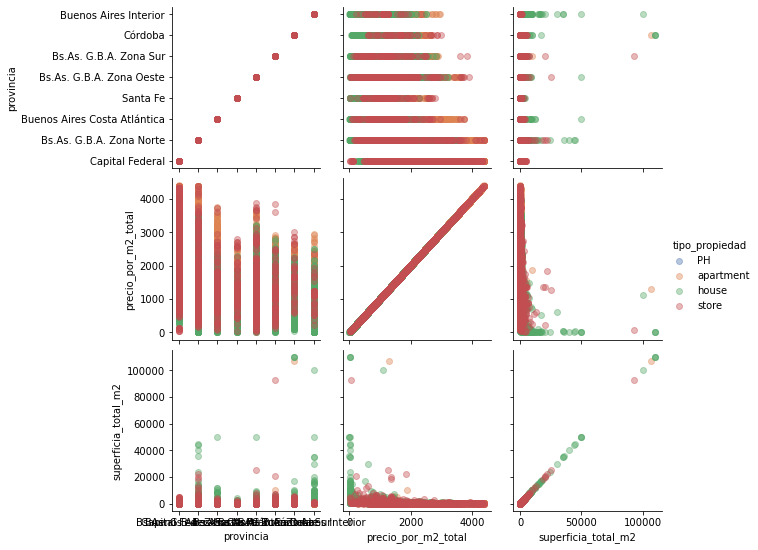

In [55]:
suburb_values = ['PH', 'house', 'apartment', 'store']

data_suburb_mask = data_provincias.tipo_propiedad.apply(lambda x: x in suburb_values)

data_suburb = data_provincias.loc[data_suburb_mask, :]
g = sns.PairGrid(data_suburb, vars=["provincia", "precio_por_m2_total", "superficia_total_m2"],
                 hue='tipo_propiedad', palette='deep')
g.map(plt.scatter, alpha=0.4)
g.add_legend();


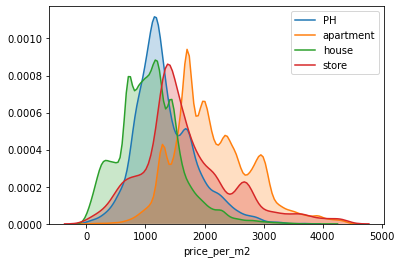

In [56]:
data_newp = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='PH']
data_newa = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='apartment']
data_newh = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='house']
data_news = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='store']
sns.kdeplot(data_newp, label='PH', shade=True)
sns.kdeplot(data_newa, label='apartment', shade=True)
sns.kdeplot(data_newh, label='house', shade=True)
sns.kdeplot(data_news, label='store', shade=True)
plt.xlabel('price_per_m2');

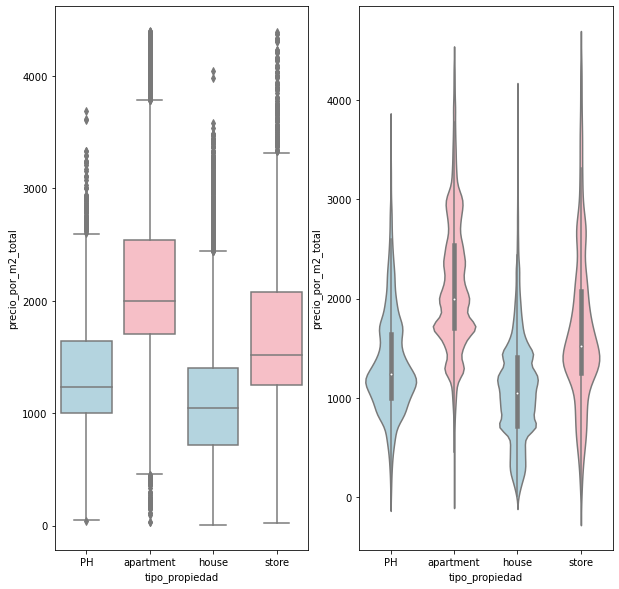

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

sns.boxplot("tipo_propiedad", "precio_por_m2_total", data=data_provincias,
               palette=["lightblue", "lightpink",], ax=axs[0])
sns.violinplot("tipo_propiedad", "precio_por_m2_total", data=data_provincias,
               palette=["lightblue", "lightpink"], ax=axs[1]);

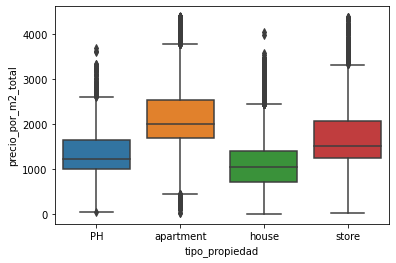

In [58]:
ax = sns.boxplot(x="tipo_propiedad", y="precio_por_m2_total", data=data_provincias)

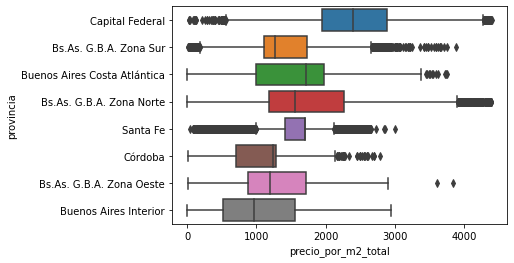

In [59]:
data_ser = data_provincias["provincia"]
ax = sns.boxplot(x="precio_por_m2_total",  y=data_ser, data=data_provincias)

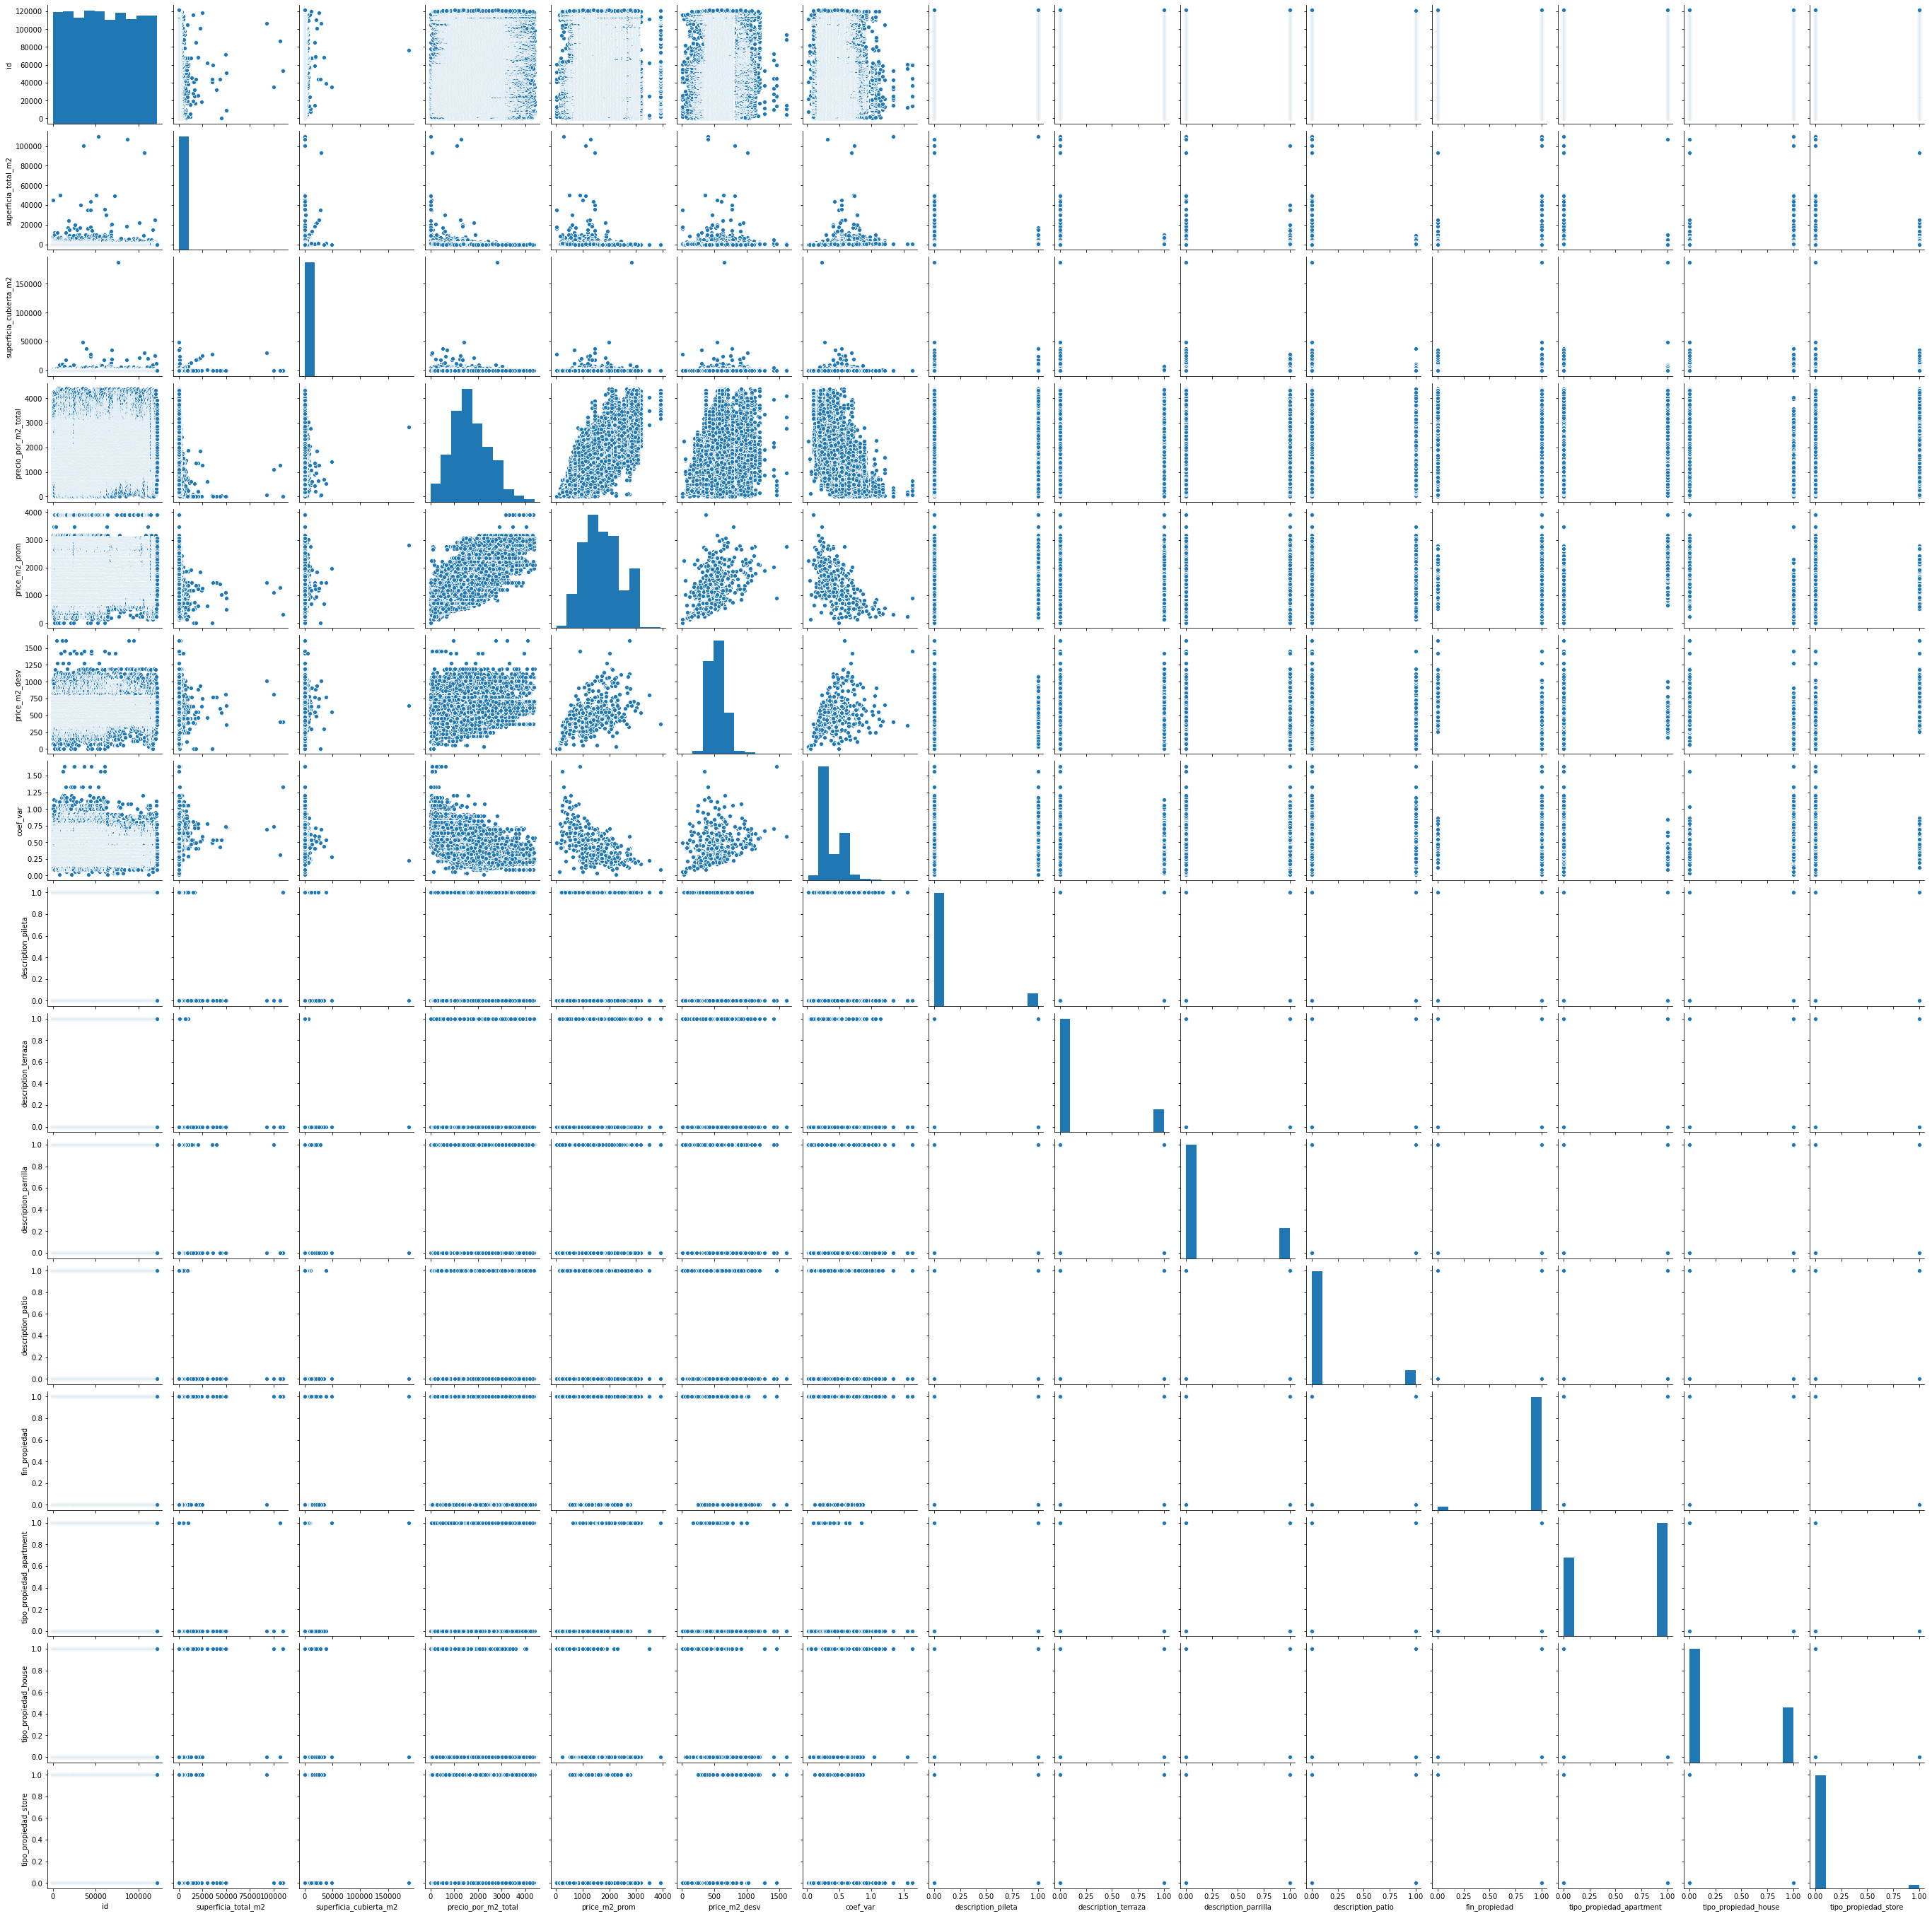

In [60]:
sns.pairplot(data_provincias)

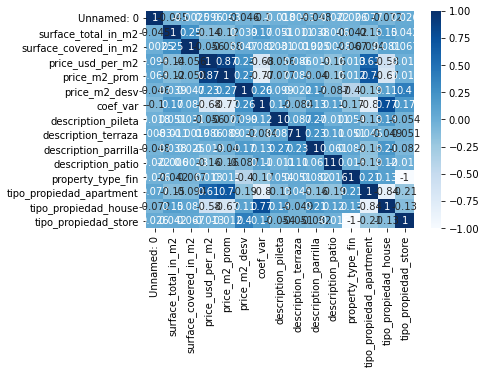

In [61]:
sns.heatmap(data_sin_columnas.corr(), annot=True, vmin=-1, cmap='Blues');

<AxesSubplot:xlabel='tipo_propiedad', ylabel='precio_por_m2_total'>

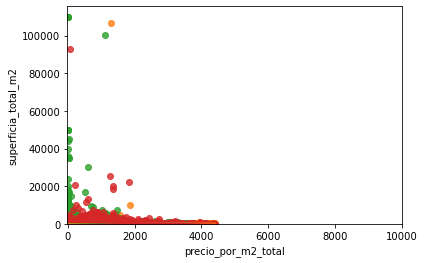

In [121]:

data_newp = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='PH']
data_newpy = data_provincias.superficia_total_m2[data_provincias.tipo_propiedad=='PH']
data_newa = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='apartment']
data_neway = data_provincias.superficia_total_m2[data_provincias.tipo_propiedad=='apartment']
data_newh = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='house']
data_newhy = data_provincias.superficia_total_m2[data_provincias.tipo_propiedad=='house']
data_news = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='store']
data_newsy = data_provincias.superficia_total_m2[data_provincias.tipo_propiedad=='store']
sns.regplot(data_newp, data_newpy,label='PH')
sns.regplot(data_newa, data_neway,label='apartment')
sns.regplot(data_newh, data_newhy,label='house')
sns.regplot(data_news, data_newsy,label='store')
#sns.regplot(data_provincias.superficia_total_m2, data_provincias.precio_por_m2_total, data_provincias.tipo_propiedad, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,10000)
plt.ylim(bottom=0);

sns.boxplot("tipo_propiedad", "precio_por_m2_total", data=data_provincias,
               palette=["lightblue", "lightpink",], ax=axs[0])

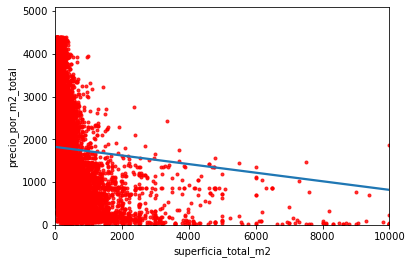

In [126]:
sns.regplot(data_provincias.superficia_total_m2, data_provincias.precio_por_m2_total, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,10000)
plt.ylim(bottom=0);


In [63]:
from sklearn.linear_model import LinearRegression

In [64]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

In [65]:
feature_cols = ['superficia_total_m2']
X = data_provincias[feature_cols]
y = data_provincias.precio_por_m2_total

# Corrobaros la shape y el tipo de cada una
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (102499, 1)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (102499,)
Type y: <class 'pandas.core.series.Series'>


In [66]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [67]:
from sklearn.naive_bayes import GaussianNB

In [68]:
model = GaussianNB()

In [69]:
feature_cols = ['superficia_total_m2', 'precio_por_m2_total']
X = data_provincias[feature_cols]
y = data_provincias.tipo_propiedad

print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (102499, 2)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (102499,)
Type y: <class 'pandas.core.series.Series'>


In [70]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [71]:
dummies_propiedad=pd.get_dummies(data_provincias["tipo_propiedad"], drop_first = True)
data_loc= data.join(dummies_propiedad)

In [122]:
feature_cols = ['superficia_total_m2', 'precio_por_m2_total']
X = data_provincias[feature_cols]
y = dummies_propiedad

print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (102499, 2)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (102499, 3)
Type y: <class 'pandas.core.frame.DataFrame'>


In [123]:
model.fit(Xtrain, ytrain)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [91]:
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
map_options = GMapOptions(lat=-34.61, lng=-58.45, map_type="roadmap", zoom=12)
# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:
gis = gmap("your_api_key", map_options, title="Ciudad de Buenos Aires",plot_width=800, plot_height=800)
source = ColumnDataSource(
    data=dict(lat=data_original['lat'],
              lon=data_original['lon'],
              )
)
gis.circle(x="lon", y="lat", size="size", fill_color="blue", fill_alpha=0.4, source=source)
detail(gis.circle())

NameError: name 'detail' is not defined